# Protein Latent Diffusion

We have explored protein generation with EGNN as well as EDM in the previous sections. Both of which enforce the requirements for equivariant for protein generation, which are more restrictive as it focus on more local geometric consistency. We attempted a simpler version of protein generation by capturing its distribution within the latent representation, then perform diffusion process with the latent representation. After which we decode the denoised latent representation back original dimensions. 

## Load Required Libraries
Making use of Deep Graph Library and PyTorch, we build the model with the provided tools within these 2 libraries. Along with some visualization tools such as Matplotlib. 


In [1]:

import data_read
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import dgl
from dgl import DGLGraph
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
from dgl.nn import GraphConv, EGNNConv
import matplotlib.pyplot as plt
import numpy as np
from itertools import chain


## Dataset

for the dataset, we have opted for FoldingDiff CATH S40 training dataset available in https://zenodo.org/records/8388270, we also selected the PDB files which has consistent/clean data for our training purpose listed in `clean_pdb_id.txt`.

In [2]:
pdb_dir ='data/dompdb/'
list_path = 'data/clean_pdb_id.txt'

In [3]:
with open(list_path) as file:
    lines = [line.rstrip() for line in file]

print(len(lines))

31065


We have 31065 protein data. Each protein have varying sizes of long sequence.

Same process to get the backbone of the protein from each PDB file. 

In [4]:
def input_generation(pdb_path):
    """
    Args:
        pdb_path (str): the path to the protein pdb file
    Returns:
        frames (tensor(n_aa x 4 x 3)): a tensor presenting 3D coordinates
        seq (str): a sequence of characters representing the amino acids in the protein backbone
    """
    frames, seq = data_read.get_backbone(pdb_path)
    frames = torch.from_numpy(frames[0]); seq = seq[0]
    frames = frames.to(torch.float32)
    n = len(seq)

    return frames, seq

`input_generation` is used to extracted the backbone of each protein PDB file. The frames and seq returned each represent the 3D coordinates and the a sequence of amino acids types denoted by letters.

For `frames`, the dimensions is of (number of amino acids x 4 x 3). Dimension 1 is the same as the length of the `seq`. Second dimension of 4 represent different atoms within an amino acid, we only selected main 4 representing N, CA, C, CB (set to `0,0,0` if the amino acid is GLY) to reduce the length and variations of huge protein compositions.

## Process Data
We will process the data such that the required graphs, coordinates, amino acids sequences are constructed for model building process.

For data to be used with `DGL.EGNN`, we have added edges between the backbone carbon as well as edges between the C and CA, N, CB corresponding to an amino acid. The edge data is calculated with the coordinates using Euclidean distance. 

In [29]:
def process_protein_data(num_graph, model):
    """
    Args:
        num_graph (int): number of graphs to be extracted from the list
        model (str): which model "egnn" or "normal"
    Returns: 
        graphs - graphs contructed from the protein files - length = num_graph
        list_of_frames - a list of 3D coordinates [(n_aa, 4, 3)], length = num_graph
        list_of_seqs = a list of aa sequences [(n_aa, 4, 3)], length = length = num_graph
        num_categories = number of unique characters for the sequences
    """
    file_names = lines[:num_graph]
    graphs, list_of_frames, list_of_nodes, seqs, i_seqs, dist_list = [], [], [], [], [], []
    long_seq = ""
    for protein in file_names:
        pdb_path = pdb_dir + protein
        frames, seq = input_generation(pdb_path)
        i_seq = data_read.encode(seq)
        
        # each node/amino acid has 4 atoms 
        nodes_seq = [num for num in i_seq for _ in range(4)]
        # process frame into stacked 3D coordinates
        frames = frames.view(-1, 3)
        
        # Do Standard Normalization on the 3D coordinates
        mean_frames = frames.mean(dim=0)
        std_frames = frames.std(dim=0)
        
        normalized_frames = (frames - mean_frames)/ std_frames
        
        if model == "egnn":
            i_nodes = [i for i in range(len(nodes_seq))]
            # getting all the cardbon position
            c_positions = i_nodes[2::4]
            n_positions = i_nodes[0::4]
            ca_positions = i_nodes[1::4]
            cb_positions = i_nodes[3::4]
            
            # Create edges between consecutive carbon, for the backbone chain
            src = c_positions[:-1]  # Start nodes
            dst = c_positions[1:]   # End nodes
            
            # add edges for N connecting to C
            src.extend(n_positions)
            dst.extend(c_positions)
            
            # add edges for CA connecting to C
            src.extend(ca_positions)
            dst.extend(c_positions)
            
            # add edges for CB connecting to C
            src.extend(cb_positions)
            dst.extend(c_positions)    
            
            
            # Convert to tensors
            src_tensor = torch.tensor(src)
            dst_tensor = torch.tensor(dst)
            
            
            g = dgl.graph((src_tensor, dst_tensor), num_nodes=len(nodes_seq))
            g.ndata["aa"] = torch.tensor(nodes_seq)
            
            
            g.ndata["coords"] = normalized_frames
            
            # calculate the euclidean for all edges
            src_coords = torch.vstack([normalized_frames[i] for i in src])
            dst_coords =torch.vstack([normalized_frames[i] for i in dst])
        
            edge_feats = torch.norm(src_coords - dst_coords, dim=1)
            g.edata["dist"] = edge_feats
            dist_list.append(edge_feats)
            
            # g = dgl.add_self_loop(g)
            graphs.append(g)
        else:   
            num_nodes = len(seq) * 4
            g = dgl.graph(([], []), num_nodes=num_nodes)
            g = dgl.add_self_loop(g)
            graphs.append(g)
            
        list_of_frames.append(normalized_frames)
        seqs.append(seq) 
        i_seqs.append(i_seq)
        list_of_nodes.append(nodes_seq)
        
            
        long_seq += seq
    
    num_categories = len(set(long_seq))
    return graphs, list_of_frames, list_of_nodes, seqs, i_seqs, num_categories, dist_list


graphs, list_of_frames, list_of_nodes, seqs, i_seqs, num_categories, dist_list = process_protein_data(1, "egnn")


In [31]:
# the database is quite big, limiting the number of graph/protein to avoid oom issue
num_graph = 10000
graphs_normal, list_of_frames_normal, list_of_nodes_normal, seqs_normal, i_seqs_normal, num_categories_normal, dist_list_normal = process_protein_data(num_graph, "normal")
graphs_egnn, list_of_frames_egnn, list_of_nodes_egnn, seqs_egnn, i_seqs_egnn, num_categories_egnn, dist_list_egnn = process_protein_data(num_graph, "egnn")


## Plot Protein
Plotting the protein to visualize how each protein looks. Each atom is in different color and only the connecting backbone through the C is connected in the plot for easier visualization. 

(1308, 3)


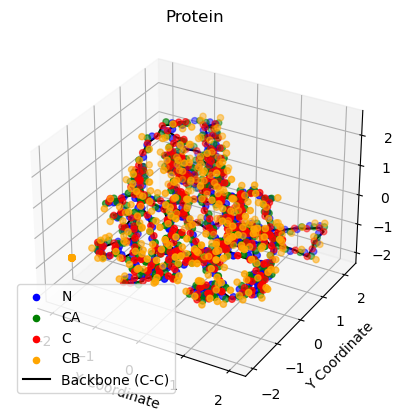

(496, 3)


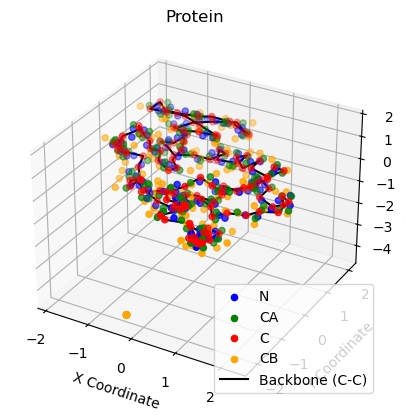

In [32]:
def plot_protein(frames):
    """
    Take in a list of 3D coordinates representing amino acids and plot a protein diagram
    Args: 
        frame: 3D coordinates generated by backbone. Shape - n_aa x 4 x 3
            second dimension representing N, CA, C, CB
    Returns: -
    """
    print(frames.shape)
    N_coords, CA_coords, C_coords, CB_coords = [], [], [], []
    N_coords = frames[0::4]
    CA_coords = frames[1::4]
    C_coords = frames[2::4]
    CB_coords = frames[3::4]
    
    # Plotting
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(N_coords[:, 0], N_coords[:, 1], N_coords[:, 2], label='N', color='blue')
    ax.scatter(CA_coords[:, 0], CA_coords[:, 1], CA_coords[:, 2], label='CA', color='green')
    ax.scatter(C_coords[:, 0], C_coords[:, 1], C_coords[:, 2], label='C', color='red')
    ax.scatter(CB_coords[:, 0], CB_coords[:, 1], CB_coords[:, 2], label='CB', color='orange')
    
    ax.plot(C_coords[:, 0], C_coords[:, 1], C_coords[:, 2], color='black', label='Backbone (C-C)')
    
    # Labeling
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_zlabel('Z Coordinate')
    ax.legend()
    ax.set_title('Protein')
    
    # Show plot
    plt.show()

plot_protein(list_of_frames_normal[0].numpy())
plot_protein(list_of_frames_egnn[1].numpy())

## Create the Dataset

In [33]:
class GraphDataset(Dataset):
    def __init__(self, graphs, node_features, coordinates, distances):
        self.graphs = graphs
        self.node_features = node_features
        self.coordinates = coordinates
        self.distances = distances

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        coords = self.coordinates[idx]
        features = self.node_features[idx]
        if len(self.distances) > 0:
            return self.graphs[idx], features, coords, self.distances[idx]
        else:
            return self.graphs[idx], features, coords, []
        

In [34]:
dataset_egnn = GraphDataset(graphs_egnn, list_of_nodes_egnn, list_of_frames_egnn, dist_list_egnn)
dataset_normal = GraphDataset(graphs_normal, list_of_nodes_normal, list_of_frames_normal, dist_list_normal)

Doing a 80-10-10 split for training, validation, and testing process. 

In [35]:
dataset_size = len(lines) # 31065
dataset_size = num_graph

# Define the split ratios
train_ratio, val_ratio, test_ratio = 0.8, 0.1, 0.1
train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset_egnn, val_dataset_egnn, test_dataset_egnn = random_split(
    dataset_egnn, [train_size, val_size, test_size]
)

train_dataset_normal, val_dataset_normal, test_dataset_normal = random_split(
    dataset_normal, [train_size, val_size, test_size]
)


Defining a collate function for batching graph, protein graphs of varying sizes will be batched in this function with Dataloader.

In [36]:
def collate_fn(batch):
    """
    Collates a batch of graphs and their features into a batched graph.
    """
    graphs, features, coordinates, distances = map(list, zip(*batch))
    batched_graph = dgl.batch(graphs)
    flattened_features = list(chain.from_iterable(features))
    # Combine node features across the batch
    batch_categorical = torch.tensor(flattened_features)
    batch_continuous = torch.cat(coordinates)    

    return batched_graph, batch_categorical, batch_continuous, distances

Selecting batch size of 4 (small number as the protein length can reach up to thousands in one file.)


In [37]:
batch_size = 4 
train_loader_egnn = DataLoader(train_dataset_egnn, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
val_loader_egnn = DataLoader(val_dataset_egnn, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader_egnn = DataLoader(test_dataset_egnn, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

train_loader_normal = DataLoader(train_dataset_normal, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
val_loader_normal = DataLoader(val_dataset_normal, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader_normal = DataLoader(test_dataset_normal, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

## Models

### Latent Diffusion
Baseline: Using graph convolution layer for all 3 stages: encoding, denoising, and decoding. There are both categorical and continuous data type. Therefore, before encoding the data into latent representation, categorical data is embedded using `nn.Embedding`. Then the resulting embedding is concatenated with the continuous 3D coordinates data. 

DGL.GraphConv is used to encode the original embedded data into latent representations. Noise is then added to the latent representations, and another DGL.GraphConv is used to denoise the noisy latent representation. Once denoised, another graph convolution layer is used to decode latent representation to original dimensions. 

In [38]:
class BatchedLatentDiffusionAutoencoder(nn.Module):
    def __init__(self, num_categories, embedding_dim, continuous_dim, latent_dim, diffusion_steps):
        super().__init__()
        
        # Embedding layer for categorical features
        self.embedding = nn.Embedding(num_categories, embedding_dim)
        
        # Graph convolutional encoder
        input_dim = embedding_dim + continuous_dim
        self.gcn_encoder = GraphConv(input_dim, latent_dim, allow_zero_in_degree=True)
        
        # Diffusion process
        self.diffusion_steps = diffusion_steps
        self.noise_scheduler = self.get_noise_scheduler(diffusion_steps)
        self.denoising_model = GraphConv(latent_dim, latent_dim, allow_zero_in_degree=True)
        
        # Graph convolutional decoder
        self.gcn_decoder = GraphConv(latent_dim, input_dim, allow_zero_in_degree=True)
        
        # Output heads for reconstruction
        self.cat_decoder = nn.Linear(embedding_dim, num_categories)  # Categorical reconstruction
        self.cont_decoder = nn.Linear(continuous_dim, continuous_dim)  # Continuous reconstruction

    def get_noise_scheduler(self, steps):
        # Linear noise schedule for simplicity
        return torch.linspace(0.01, 0.1, steps)

    def forward(self, g, categorical, continuous, t):
        # Node embeddings for categorical features
        cat_embedded = self.embedding(categorical)
        # Concatenate embeddings with continuous features
        node_features = torch.cat([cat_embedded, continuous], dim=-1)
        # Encode node features into latent space
        latent = self.gcn_encoder(g, node_features)
        
        # Diffusion process
        noise_level = self.noise_scheduler[t]
        noise = torch.randn_like(latent) * noise_level
        noisy_latent = latent + noise
        
        # Denoise latent space
        denoised_latent = self.denoising_model(g, noisy_latent)
        
        # Decode to original feature space
        decoded = self.gcn_decoder(g, denoised_latent)
        
        # Split decoded output
        decoded_cat = self.cat_decoder(decoded[:, :cat_embedded.size(-1)])
        decoded_cont = self.cont_decoder(decoded[:, cat_embedded.size(-1):])
        
        
        return decoded_cat, decoded_cont, latent, denoised_latent

### Equivariant Latent Diffusion

Since our project focuses on preserving the equivariant property of nodes in the graph. Using EGNN as main convolution model for all stages: encoding, denoising and decoding. 

Similar approach has been used as baseline, replacing DGL.GraphConv with DGL.EGNN to see if there will be improvement in training and inference.  

In [39]:

class EquivariantDiffusionAutoencoder(nn.Module):
    def __init__(self, num_categories, embedding_dim, continuous_dim, latent_dim, diffusion_steps):
        super().__init__()
        
        # Embedding layer for categorical features
        self.embedding = nn.Embedding(num_categories, embedding_dim)
        
        # Graph convolutional encoder
        # Choosing 20 for the hidden layer inside EGNN
        self.egnn_encoder = EGNNConv(embedding_dim, 20, latent_dim)
        
        # Diffusion process
        self.diffusion_steps = diffusion_steps
        self.noise_scheduler = self.get_noise_scheduler(diffusion_steps)
        self.denoising_model = EGNNConv(latent_dim, 20, latent_dim)
        
        # Graph convolutional decoder
        self.egnn_decoder = EGNNConv(latent_dim, 20, embedding_dim)
        
        # Output heads for reconstruction
        self.cat_decoder = nn.Linear(embedding_dim, num_categories)  # Categorical reconstruction
        self.cont_decoder = nn.Linear(continuous_dim, continuous_dim)  # Continuous reconstruction

    def get_noise_scheduler(self, steps):
        # Linear noise schedule for simplicity
        return torch.linspace(0.01, 0.1, steps)

    def forward(self, g, categorical, continuous, t):
        # Node embeddings for categorical features
        cat_embedded = self.embedding(categorical)
        continuous = (continuous - continuous.mean(dim=0))/(continuous.std(dim=0)+1e-5)
        # Encode node features into latent space
        latent_node_features, latent_coords = self.egnn_encoder(g, cat_embedded, continuous)
        # Diffusion process
        noise_level = self.noise_scheduler[t]
        noise_node = torch.randn_like(latent_node_features) * noise_level
        noise_coords = torch.randn_like(latent_coords) * noise_level
        noisy_node_features = latent_node_features + noise_node
        noisy_coords = latent_coords + noise_coords
       
        # Denoise latent space
        denoised_node_features, denoised_coords = self.denoising_model(g, noisy_node_features, noisy_coords)
        # Decode to original feature space
        reconstructed_cat, reconstructed_cont = self.egnn_decoder(g, denoised_node_features, denoised_coords)
        
        # Split decoded output
        decoded_cat = self.cat_decoder(reconstructed_cat)
        decoded_cont = self.cont_decoder(reconstructed_cont)
        cat_output = torch.argmax(F.softmax(decoded_cat, dim=-1), dim=-1)

        
        return cat_output, decoded_cont, latent_node_features, latent_coords

## Loss Function

2 types of loss function has been defined. Since we are doing a latent diffusion, the diffusion loss and reconstruction loss are considered. For reconstruction loss, Cross Entropy Loss is used for categorical amino acid type data while MSE loss is used for the continuous 3D coordinates data. 

In [40]:
# Loss functions
def diffusion_loss(latent, denoised_latent, noise):
    return F.mse_loss(denoised_latent, latent - noise)

def reconstruction_loss(original_cat, reconstructed_cat, original_cont, reconstructed_cont):
    # Categorical loss
    cat_loss = nn.CrossEntropyLoss()(reconstructed_cat, original_cat)
    
    # Continuous loss
    cont_loss = nn.MSELoss()(reconstructed_cont, original_cont)
    
    # Combine losses
    return cat_loss + cont_loss

# Training

Setting the hyperparameters before training. 

In [41]:
# Hyperparameters
embedding_dim = 20   # Embedding size for categorical data
continuous_dim = 3  # Dimensionality of continuous features
latent_dim = 100     # Latent space size

### Training with `EquivariantDiffusionAutoencoder`

In [42]:
# Initialize the model
diffusion_steps = 10
num_categories = 20
model_egnn = EquivariantDiffusionAutoencoder(num_categories=num_categories, embedding_dim=embedding_dim, continuous_dim=continuous_dim, latent_dim=latent_dim, diffusion_steps=diffusion_steps)

optimizer = torch.optim.Adam(model_egnn.parameters(), lr=0.01)
epoch_losses_egnn = []
# Training loop
for epoch in range(50):
    epoch_loss = 0
    
    for batched_graph, batch_categorical, batch_continuous, batch_distances in train_loader_egnn:
        # Randomly sample a diffusion step
        t = torch.randint(0, diffusion_steps, (1,)).item()
        
        # Forward pass
        reconstructed_cat, reconstructed_cont, latent_nodes, latent_coords = model_egnn(
            batched_graph, batch_categorical, batch_continuous, t
        )
        
        loss_cat = nn.CrossEntropyLoss()(reconstructed_cat.float(), batch_categorical.float())
        loss_coord = nn.MSELoss()(reconstructed_cont.float(), batch_continuous.float())
        # Combine losses
        loss = loss_cat + loss_coord
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        # for name, param in model.named_parameters():
        #     if param.grad is not None:
        #             print(f"{name}: Gradient norm: {param.grad.norm()}")
        torch.nn.utils.clip_grad_norm_(model_egnn.parameters(), max_norm=1.0)

        optimizer.step()
        
        epoch_loss += loss.item()
    epoch_losses_egnn.append(epoch_loss)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

Epoch 1, Loss: 337764661.3633
Epoch 2, Loss: 336866305.0039
Epoch 3, Loss: 390329091.1406
Epoch 4, Loss: 407813458.4688
Epoch 5, Loss: 334697573.6680
Epoch 6, Loss: 334838763.1562
Epoch 7, Loss: 334697573.7656
Epoch 8, Loss: 336899060.2930
Epoch 9, Loss: 509734515.5859
Epoch 10, Loss: 597670563.2734
Epoch 11, Loss: 475421433.1875
Epoch 12, Loss: 462369136.3555
Epoch 13, Loss: 442899180.0078
Epoch 14, Loss: 363554542.7617
Epoch 15, Loss: 431928301.3477
Epoch 16, Loss: 486014488.7734
Epoch 17, Loss: 491328612.1562
Epoch 18, Loss: 351904134.8633
Epoch 19, Loss: 344299727.6914
Epoch 20, Loss: 338076093.8203
Epoch 21, Loss: 427925100.9258
Epoch 22, Loss: 497486841.3203
Epoch 23, Loss: 502264053.0391
Epoch 24, Loss: 417631595.3242
Epoch 25, Loss: 509077174.6602
Epoch 26, Loss: 538165071.3125
Epoch 27, Loss: 493609292.9258
Epoch 28, Loss: 345325182.4297
Epoch 29, Loss: 385436177.2969
Epoch 30, Loss: 441886655.7578
Epoch 31, Loss: 442440993.3750
Epoch 32, Loss: 443206551.2148
Epoch 33, Loss: 3

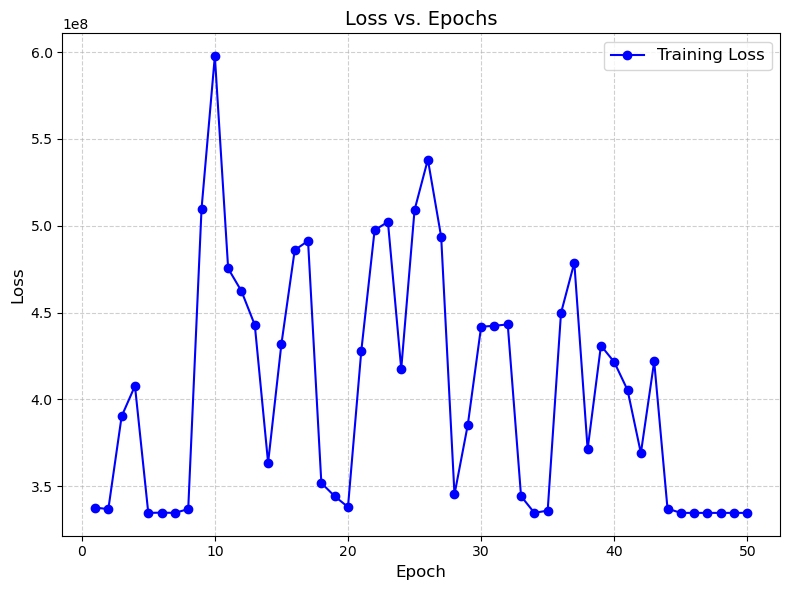

In [43]:
# Generate epochs
epochs = range(1, len(epoch_losses_egnn) + 1)

# Plot the loss chart
plt.figure(figsize=(8, 6))
plt.plot(epochs, epoch_losses_egnn, marker='o', linestyle='-', color='b', label='Training Loss')
plt.title('Loss vs. Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

The training loss is very high through out the epochs. Although it seems to stabilise towards the end of training, loss remain high. Many reasons could be causing this including the simply setup in the model, edge definition was not defined well, perhaps the model or EGNN is not used appropriately, etc.

#### Generate protein with `EquivariantLatentAutoencoder`

In [44]:
def reverse_diffusion_egnn(model, g, num_nodes, diffusion_steps):
    """
    Perform reverse diffusion to generate latent states.

    Args:
        model: The trained EquivariantDiffusionAutoencoder model.
        g: DGLGraph object (can be empty if generating new graph data).
        num_nodes: Number of nodes for which data is being generated.
        diffusion_steps: Number of diffusion steps.

    Returns:
        Denoised node features and coordinates.
    """
    # Initialize random latent states
    latent_node_features = torch.randn((num_nodes, latent_dim))
    latent_coords = torch.randn((num_nodes, 3))  # Assuming 3D coordinates
    
    # Reverse diffusion: step through time steps in reverse
    for t in reversed(range(diffusion_steps)):
        noise_level = model.noise_scheduler[t]
        noise_node = torch.randn_like(latent_node_features) * noise_level
        noise_coords = torch.randn_like(latent_coords) * noise_level

        # Add noise to latent states
        noisy_node_features = latent_node_features + noise_node
        noisy_coords = latent_coords + noise_coords
        
        # Denoise the latent states
        latent_node_features, latent_coords = model.denoising_model(g, noisy_node_features, noisy_coords)

    return latent_node_features, latent_coords


In [45]:
def generate_data_egnn(model, g, num_nodes, diffusion_steps):
    """
    Generate categorical and continuous node features with coordinates.

    Args:
        model: The trained EquivariantDiffusionAutoencoder model.
        g: DGLGraph object (can be empty).
        num_nodes: Number of nodes for which data is being generated.
        diffusion_steps: Number of diffusion steps.

    Returns:
        Generated categorical features, continuous features, and coordinates.
    """
    # Step 1: Reverse diffusion to get latent representations
    latent_node_features, latent_coords = reverse_diffusion_egnn(model, g, num_nodes, diffusion_steps)
    
    
    # Step 2: Decode the latent representations into original features
    reconstructed_cat, reconstructed_cont = model.egnn_decoder(g, latent_node_features, latent_coords)

    # Step 3: Decode categorical and continuous features
    decoded_cat = model.cat_decoder(reconstructed_cat)
    generated_cat = torch.argmax(torch.softmax(decoded_cat, dim=-1), dim=-1)  # Choose most likely category
    generated_cont = model.cont_decoder(reconstructed_cont)

    return generated_cat, generated_cont, latent_coords


/Users/siowchuen/anaconda3/envs/gnn_project/lib/python3.8/site-packages/dgl/core.py:84: DGLWarning: The input graph for the user-defined edge function does not contain valid edges
  dgl_warning(


(768, 3)
(768, 3)


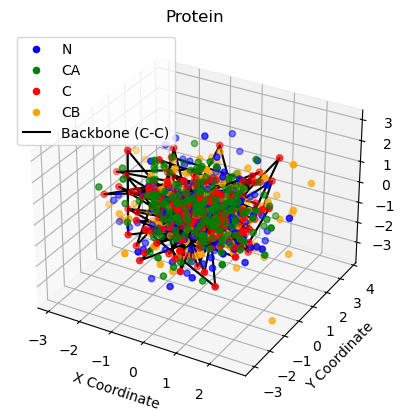

(408, 3)


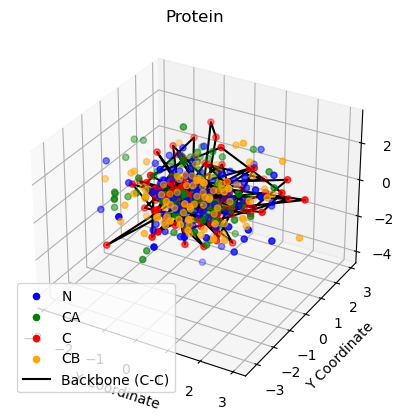

(132, 3)


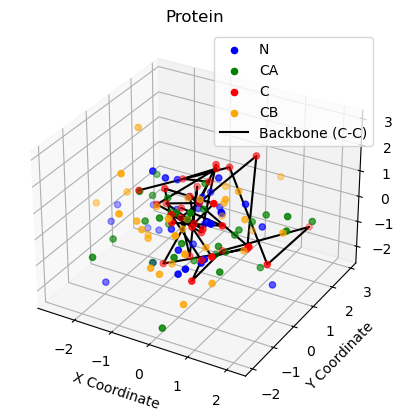

In [53]:
generated_seqs = []
for batched_graph, batch_categorical, batch_continuous, batch_distances in val_loader_egnn:
    individual_graphs = dgl.unbatch(batched_graph)
    # Check the unbatched graphs
    for i, g in enumerate(individual_graphs):

        # Define the number of nodes for the graph
        num_nodes = g.num_nodes()
        empty_graph = dgl.graph(([],[]), num_nodes=num_nodes)

        # Generate data
        generated_cat, generated_cont, generated_coords = generate_data_egnn(
            model=model_egnn,
            g=empty_graph,
            num_nodes=num_nodes,
            diffusion_steps=model_egnn.diffusion_steps
        )
        generated_seqs.append(generated_cont.detach().numpy())

print(generated_seqs[0].shape)
plot_protein(generated_seqs[0])
plot_protein(generated_seqs[1])
plot_protein(generated_seqs[2])


### Training with `BatchedLatentDiffusionAutoencoder`

In [48]:
# Initialize the model
diffusion_steps = 10
model_normal = BatchedLatentDiffusionAutoencoder(num_categories=num_categories, embedding_dim=embedding_dim, continuous_dim=continuous_dim, latent_dim=latent_dim, diffusion_steps=diffusion_steps)
optimizer = torch.optim.Adam(model_normal.parameters(), lr=0.001)
epoch_losses_normal = []
# Training loop
for epoch in range(50):
    epoch_loss = 0
    
    for batched_graph, batch_categorical, batch_continuous, _ in train_loader_normal:
        # Randomly sample a diffusion step
        t = torch.randint(0, diffusion_steps, (1,)).item()
        
        # Forward pass
        reconstructed_cat, reconstructed_cont, latent, denoised_latent = model_normal(
            batched_graph, batch_categorical, batch_continuous, t
        )
        
        # Compute losses
        noise = torch.randn_like(latent) * model_normal.noise_scheduler[t]
        diffusion_loss = F.mse_loss(denoised_latent, latent - noise)
        reconstruction_loss = (
            nn.CrossEntropyLoss()(reconstructed_cat, batch_categorical) +
            nn.MSELoss()(reconstructed_cont, batch_continuous)
        )
        
        # Combine losses
        loss = diffusion_loss + reconstruction_loss
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    epoch_losses_normal.append(epoch_loss)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

Epoch 1, Loss: 213.9161
Epoch 2, Loss: 15.1266
Epoch 3, Loss: 11.5123
Epoch 4, Loss: 10.3957
Epoch 5, Loss: 9.8658
Epoch 6, Loss: 9.6437
Epoch 7, Loss: 9.5366
Epoch 8, Loss: 9.3927
Epoch 9, Loss: 9.1731
Epoch 10, Loss: 9.0233
Epoch 11, Loss: 8.6771
Epoch 12, Loss: 9.1102
Epoch 13, Loss: 9.0006
Epoch 14, Loss: 19.5905
Epoch 15, Loss: 9.0319
Epoch 16, Loss: 9.0816
Epoch 17, Loss: 9.1796
Epoch 18, Loss: 8.8749
Epoch 19, Loss: 9.0733
Epoch 20, Loss: 9.0259
Epoch 21, Loss: 8.7973
Epoch 22, Loss: 8.7925
Epoch 23, Loss: 24.8733
Epoch 24, Loss: 9.0358
Epoch 25, Loss: 9.0467
Epoch 26, Loss: 8.8803
Epoch 27, Loss: 8.7914
Epoch 28, Loss: 19.2719
Epoch 29, Loss: 8.8725
Epoch 30, Loss: 8.6586
Epoch 31, Loss: 8.9218
Epoch 32, Loss: 8.6699
Epoch 33, Loss: 8.9928
Epoch 34, Loss: 9.0796
Epoch 35, Loss: 8.6739
Epoch 36, Loss: 8.4806
Epoch 37, Loss: 19.6457
Epoch 38, Loss: 13.5338
Epoch 39, Loss: 8.8967
Epoch 40, Loss: 8.9633
Epoch 41, Loss: 8.5757
Epoch 42, Loss: 8.8346
Epoch 43, Loss: 8.7687
Epoch 44, 

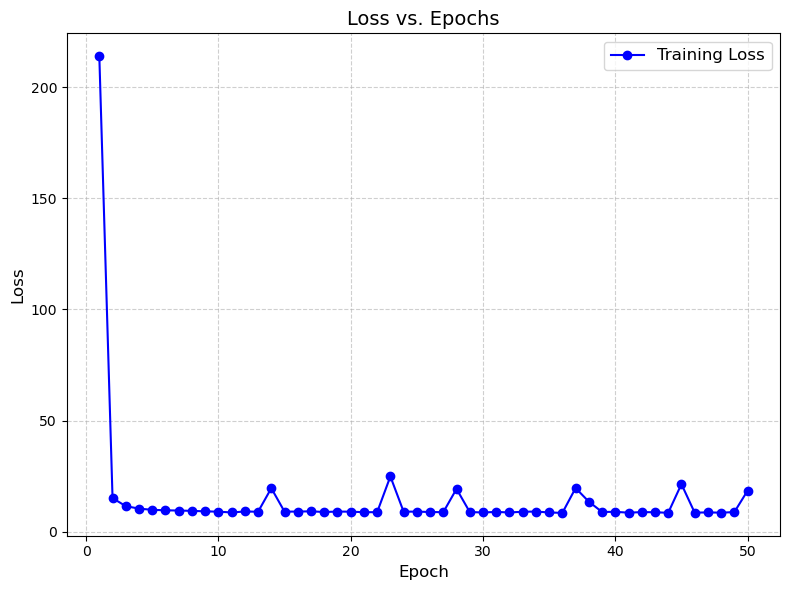

In [49]:
# Generate epochs
epochs = range(1, len(epoch_losses_normal) + 1)

# Plot the loss chart
plt.figure(figsize=(8, 6))
plt.plot(epochs, epoch_losses_normal, marker='o', linestyle='-', color='b', label='Training Loss')
plt.title('Loss vs. Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

#### Generate Data with Baseline Latent Diffusion Model

In [50]:
def reverse_diffusion_normal(model, g, num_nodes, diffusion_steps, embedding_dim, continuous_dim, latent_dim):
    # Initialize random noise (latents) for generation
    noise_level = model.noise_scheduler[diffusion_steps - 1]  # Start with the highest noise level
    in_feats = embedding_dim + continuous_dim
    latent = torch.randn(num_nodes, latent_dim).to(g.device)  # Random noise in latent space

    # Reverse the diffusion process (denoising step)
    for t in reversed(range(diffusion_steps)):
        # Denoise the latent using the trained model
        denoised_latent = model.denoising_model(g, latent)
        
        # Apply the noise scheduler at timestep t
        noise_level = model.noise_scheduler[t]
        latent = (latent - noise_level * denoised_latent) / torch.sqrt(1 - noise_level**2)
        
    # Decode the latent to original feature space
    decoded = model.gcn_decoder(g, latent)
    
    # Split decoded output into categorical and continuous
    decoded_cat = model.cat_decoder(decoded[:, :model.embedding.embedding_dim])
    decoded_cont = model.cont_decoder(decoded[:, model.embedding.embedding_dim:])
    decoded_cont = decoded_cont.detach().numpy()
    
    # Convert categorical values to the most likely class (argmax)
    cat_output = torch.argmax(F.softmax(decoded_cat, dim=-1), dim=-1)
    
    # Return generated categorical and continuous data
    return cat_output, decoded_cont

In [51]:
generated_seqs = []
for batched_graph, batch_categorical, batch_continuous, _ in val_loader_normal:
    individual_graphs = dgl.unbatch(batched_graph)
    # Check the unbatched graphs
    for i, g in enumerate(individual_graphs):
    
        num_nodes = g.num_nodes()
        generated_cat, generated_cont = reverse_diffusion_normal(model_normal, g, num_nodes, diffusion_steps=model_normal.diffusion_steps, embedding_dim=embedding_dim, continuous_dim=continuous_dim, latent_dim=latent_dim)
        generated_seqs.append(generated_cont)

1000
(192, 3)


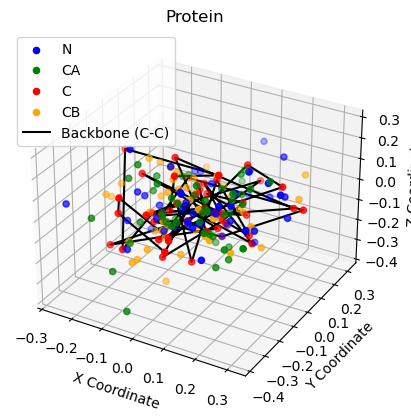

(1036, 3)


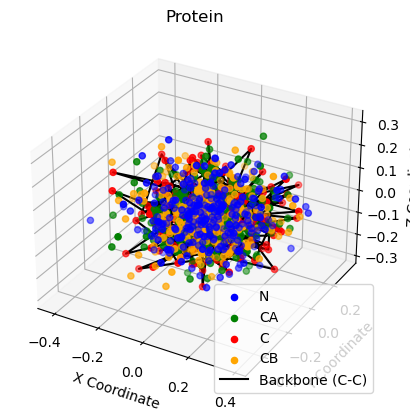

(360, 3)


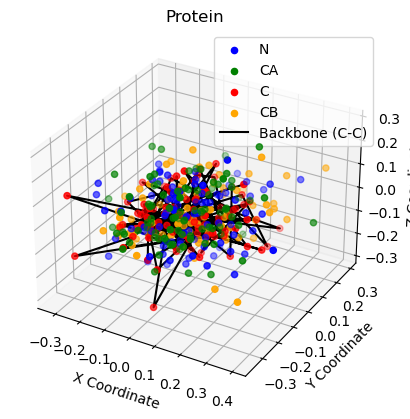

In [52]:
print(len(generated_seqs))
plot_protein(generated_seqs[0])
plot_protein(generated_seqs[1])
plot_protein(generated_seqs[2])

## Conclusion

We have attempted with QM9 Dataset with Latent Diffusion to generate data, the result seems to be more stable (in another file). But with protein file, both the model designed with DGL.EGNN and DGL.GraphConv were not able to produce good results. There could be many reasons behind it, the simple architecture being one the most obvious reason as protein graphs are still in high dimensions even though we have extracted the backbone. In addition, we have yet to consider the different folds and structure that will guide the learning process. There are still plenty of rooms for improvement. 